In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 2
commitnumber = 47e1a90
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [-2, -2, 0]
ng_refs = [2, 3, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 300
vmax = 540
vmin = 340
w_diffuse = [(1.66, 1.66), (1.8, 1.8, 1.8), (1.8, 1.66, 1.45, 1.45, 1.45, 1.45)]
wgt = [(0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6, 0.6, 0.6, 0.6)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

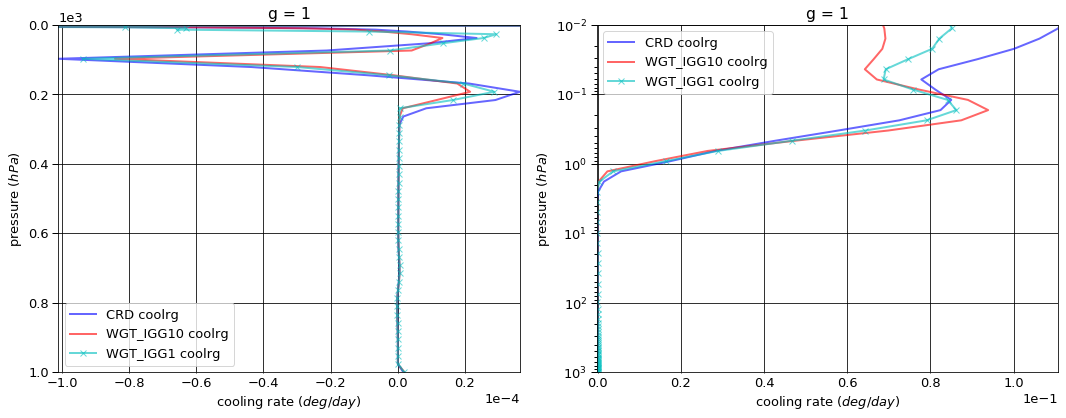

# Figure: cooling rate g-group 2

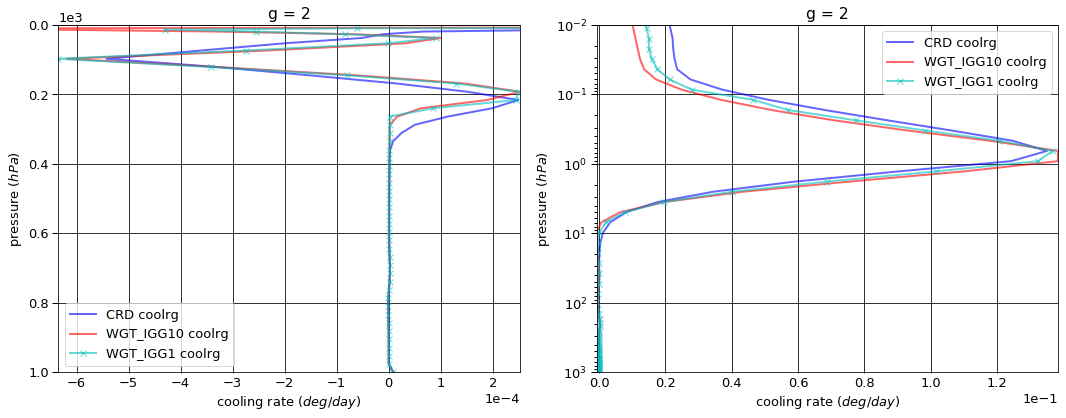

# Figure: cooling rate g-group 3

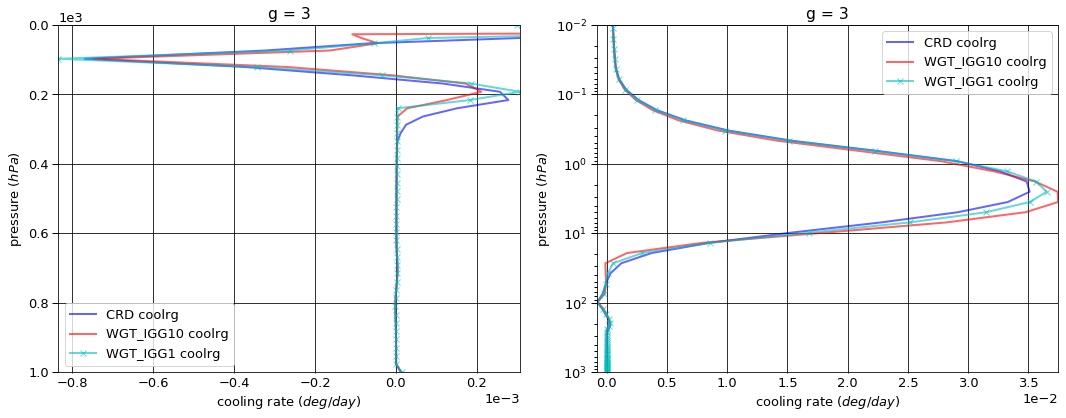

# Figure: cooling rate g-group 4

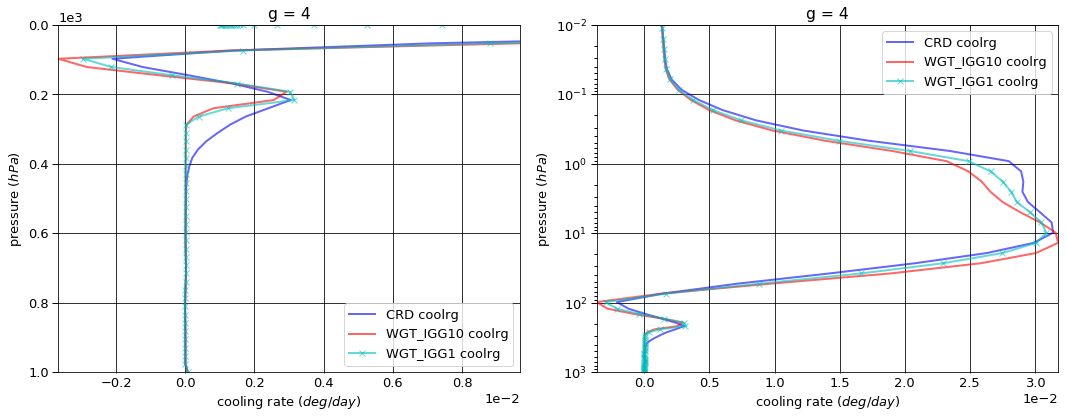

# Figure: cooling rate g-group 5

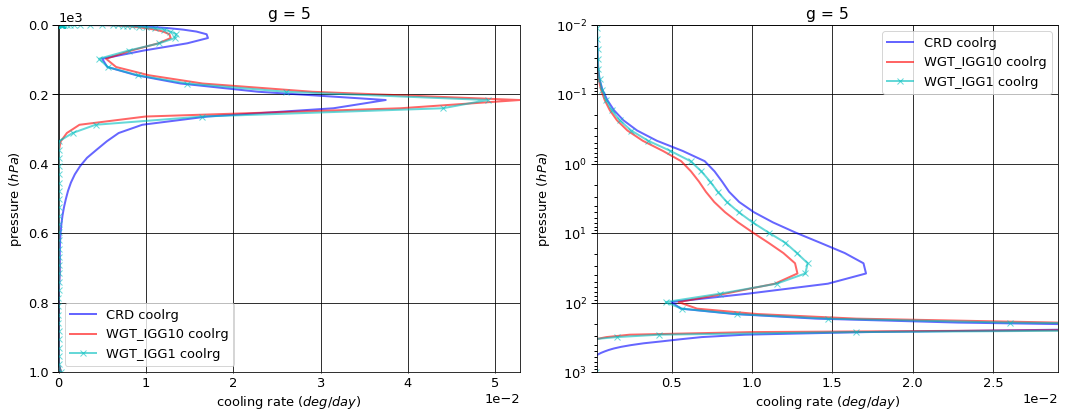

# Figure: cooling rate g-group 6

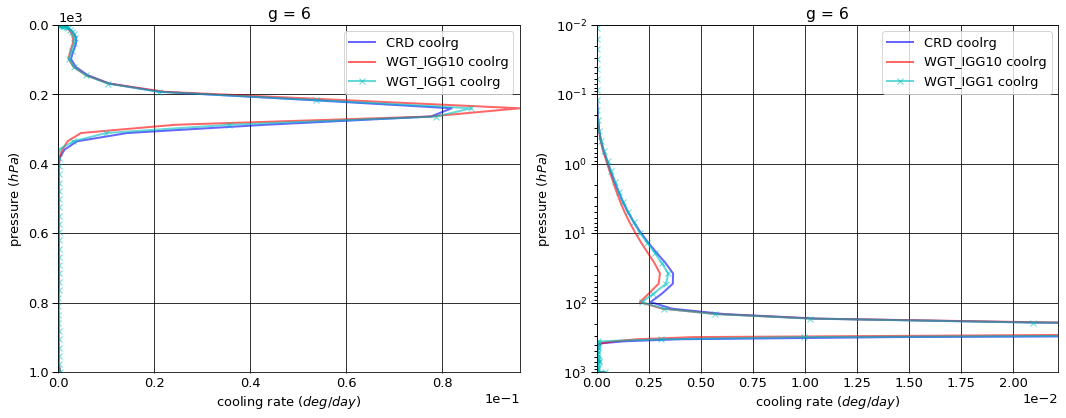

# Figure: cooling rate g-group 7

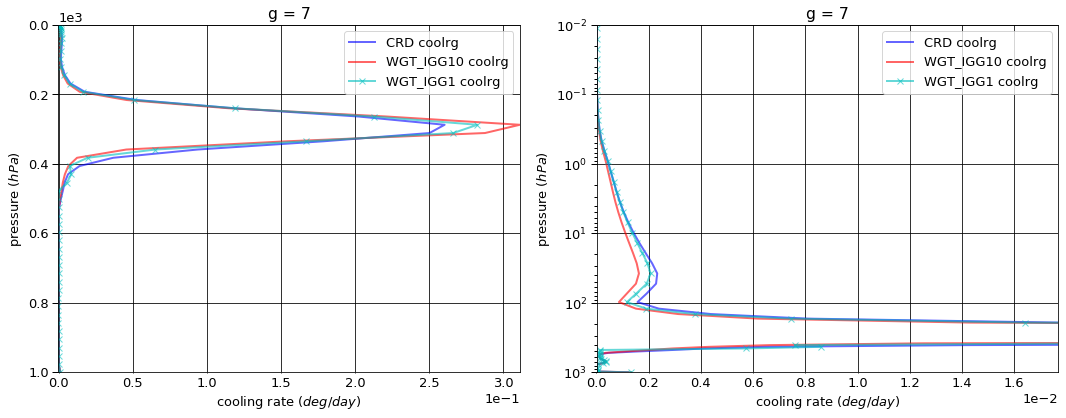

# Figure: cooling rate g-group 8

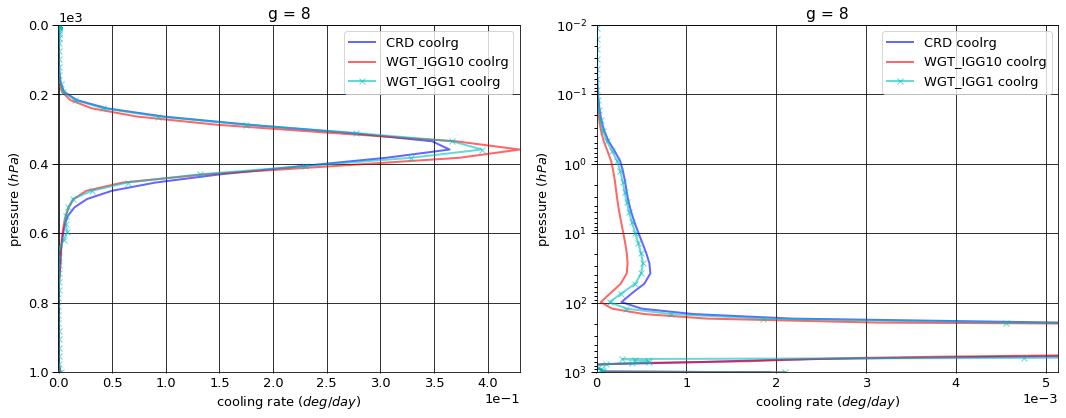

# Figure: cooling rate g-group 9

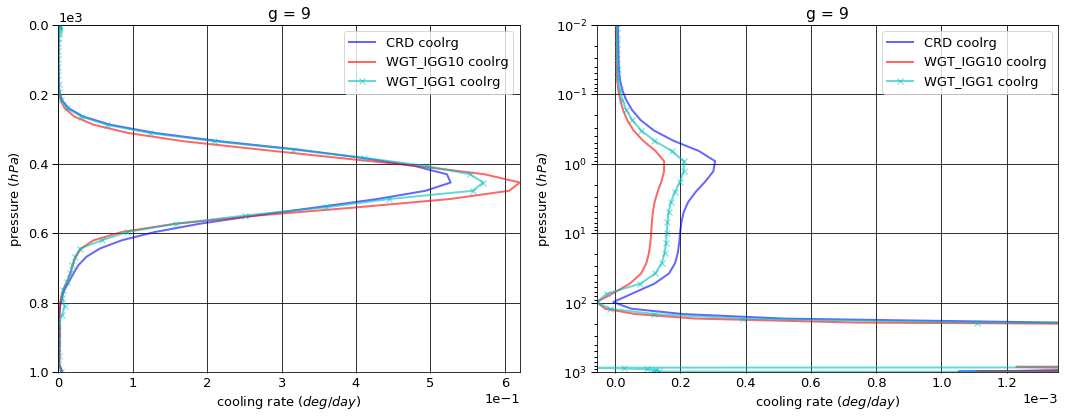

# Figure: cooling rate g-group 10

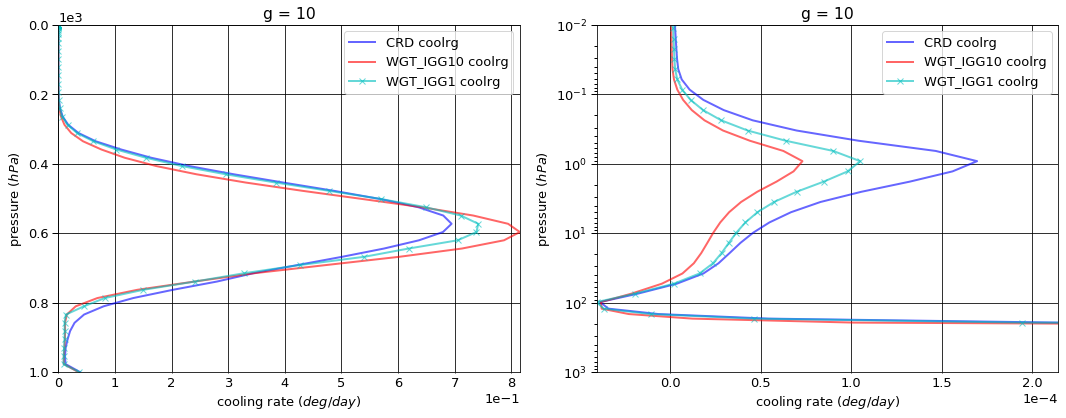

# Figure: cooling rate g-group 11

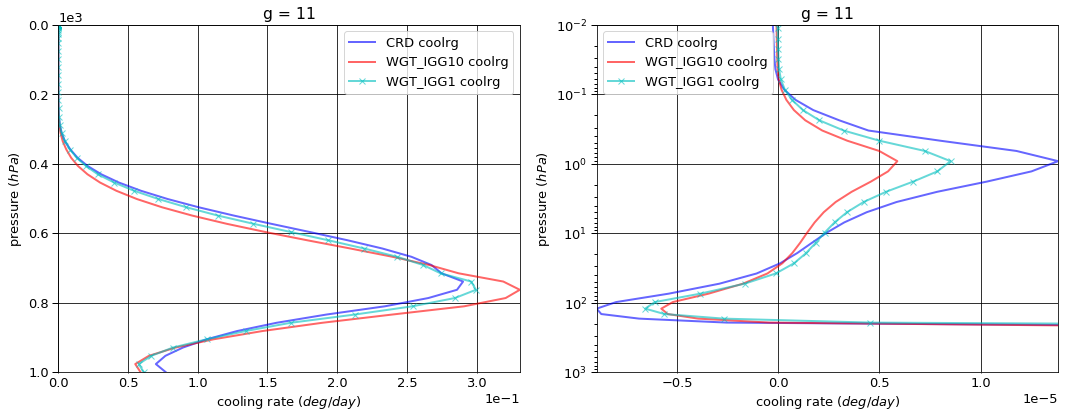

# Figure: cooling rate g-group total

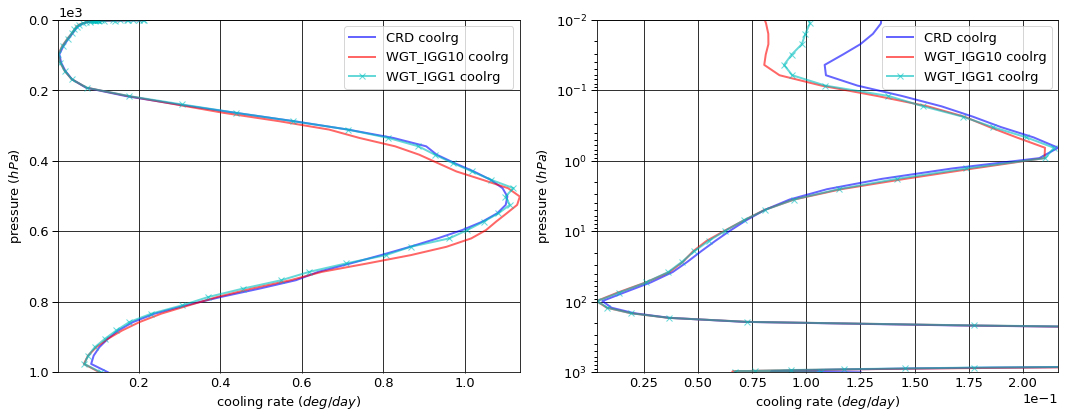

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005802   0.000000  -0.005802
   1013.0   76     -0.009730   0.009726  -0.000005
2  0.0      1      -0.029530   0.000000  -0.029530
   1013.0   76     -0.044436   0.044412  -0.000024
3  0.0      1      -0.039922   0.000000  -0.039922
   1013.0   76     -0.067355   0.067321  -0.000034
4  0.0      1      -0.171348   0.000000  -0.171348
   1013.0   76     -0.365879   0.365691  -0.000189
5  0.0      1      -0.650457   0.000000  -0.650457
   1013.0   76     -1.429126   1.428356  -0.000769
6  0.0      1      -0.934307   0.000000  -0.934307
   1013.0   76     -1.885778   1.884820  -0.000958
7  0.0      1      -3.574376   0.000000  -3.574376
   1013.0   76     -6.479185   6.475840  -0.003345
8  0.0      1      -6.289929   0.000000  -6.289929
   1013.0   76    -10.308642  10.303262  -0.005380
9  0.0      1     -13.681956   0.000000 -13.681956
   1013.0   76    -20.135346  20.121885  -0.013462
10 0.0      1     -23.910494   0.000000 -23.910494
   1013.0   76    -31.540371  31.430272  -0.110099
11 0.0      1     -11.846047   0.000000 -11.846047
   1013.0   76    -14.209382  13.718004  -0.491377


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005632   0.000000  -0.005632
   1013.0   76     -0.010261   0.010255  -0.000006
2  0.0      1      -0.030719   0.000000  -0.030719
   1013.0   76     -0.045048   0.045023  -0.000025
3  0.0      1      -0.040578   0.000000  -0.040578
   1013.0   76     -0.070012   0.069974  -0.000039
4  0.0      1      -0.161191   0.000000  -0.161191
   1013.0   76     -0.377360   0.377152  -0.000208
5  0.0      1      -0.598727   0.000000  -0.598727
   1013.0   76     -1.472836   1.472025  -0.000811
6  0.0      1      -0.898653   0.000000  -0.898653
   1013.0   76     -1.958963   1.957884  -0.001079
7  0.0      1      -3.510610   0.000000  -3.510610
   1013.0   76     -6.682441   6.678761  -0.003679
8  0.0      1      -6.287196   0.000000  -6.287196
   1013.0   76    -10.580144  10.574318  -0.005825
9  0.0      1     -13.765506   0.000000 -13.765506
   1013.0   76    -20.406826  20.394061  -0.012765
10 0.0      1     -24.015205   0.000000 -24.015205
   1013.0   76    -31.355088  31.261308  -0.093780
11 0.0      1     -11.569314   0.000000 -11.569314
   1013.0   76    -13.516252  13.256457  -0.259796


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005660   0.000000  -0.005660
   1013.0   76     -0.010261   0.010255  -0.000006
2  0.0      1      -0.030360   0.000000  -0.030360
   1013.0   76     -0.045048   0.045023  -0.000025
3  0.0      1      -0.040142   0.000000  -0.040142
   1013.0   76     -0.070012   0.069974  -0.000039
4  0.0      1      -0.160495   0.000000  -0.160495
   1013.0   76     -0.377360   0.377152  -0.000208
5  0.0      1      -0.607937   0.000000  -0.607937
   1013.0   76     -1.472836   1.472025  -0.000811
6  0.0      1      -0.905092   0.000000  -0.905092
   1013.0   76     -1.958963   1.957884  -0.001079
7  0.0      1      -3.511455   0.000000  -3.511455
   1013.0   76     -6.682441   6.678761  -0.003679
8  0.0      1      -6.235416   0.000000  -6.235416
   1013.0   76    -10.580144  10.574318  -0.005825
9  0.0      1     -13.643904   0.000000 -13.643904
   1013.0   76    -20.406826  20.395590  -0.011236
10 0.0      1     -23.792828   0.000000 -23.792828
   1013.0   76    -31.355088  31.256156  -0.098932
11 0.0      1     -11.470010   0.000000 -11.470010
   1013.0   76    -13.516252  13.230416  -0.285836


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1      0.000170  0.000000  1.704662e-04
   1013.0   76    -0.000531  0.000530 -8.698114e-07
2  0.0      1     -0.001189  0.000000 -1.188623e-03
   1013.0   76    -0.000612  0.000611 -1.016199e-06
3  0.0      1     -0.000656  0.000000 -6.560460e-04
   1013.0   76    -0.002657  0.002653 -4.360463e-06
4  0.0      1      0.010157  0.000000  1.015660e-02
   1013.0   76    -0.011480  0.011461 -1.886269e-05
5  0.0      1      0.051730  0.000000  5.173028e-02
   1013.0   76    -0.043710  0.043669 -4.164455e-05
6  0.0      1      0.035654  0.000000  3.565421e-02
   1013.0   76    -0.073185  0.073065 -1.201612e-04
7  0.0      1      0.063766  0.000000  6.376650e-02
   1013.0   76    -0.203256  0.202921 -3.343850e-04
8  0.0      1      0.002732  0.000000  2.732400e-03
   1013.0   76    -0.271502  0.271056 -4.454999e-04
9  0.0      1     -0.083550  0.000000 -8.355000e-02
   1013.0   76    -0.271480  0.272176  6.969010e-04
10 0.0      1     -0.104711  0.000000 -1.047110e-01
   1013.0   76     0.185283 -0.168964  1.631857e-02
11 0.0      1      0.276733  0.000000  2.767330e-01
   1013.0   76     0.693130 -0.461547  2.315814e-01


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1      0.000142  0.000000  1.422793e-04
   1013.0   76    -0.000531  0.000530 -8.698114e-07
2  0.0      1     -0.000829  0.000000 -8.293690e-04
   1013.0   76    -0.000612  0.000611 -1.016199e-06
3  0.0      1     -0.000220  0.000000 -2.200480e-04
   1013.0   76    -0.002657  0.002653 -4.360463e-06
4  0.0      1      0.010853  0.000000  1.085265e-02
   1013.0   76    -0.011480  0.011461 -1.886269e-05
5  0.0      1      0.042520  0.000000  4.252036e-02
   1013.0   76    -0.043710  0.043669 -4.164455e-05
6  0.0      1      0.029214  0.000000  2.921439e-02
   1013.0   76    -0.073185  0.073065 -1.201612e-04
7  0.0      1      0.062921  0.000000  6.292050e-02
   1013.0   76    -0.203256  0.202921 -3.343850e-04
8  0.0      1      0.054513  0.000000  5.451290e-02
   1013.0   76    -0.271502  0.271056 -4.454999e-04
9  0.0      1      0.038052  0.000000  3.805200e-02
   1013.0   76    -0.271480  0.273705  2.225472e-03
10 0.0      1      0.117666  0.000000  1.176660e-01
   1013.0   76     0.185283 -0.174116  1.116673e-02
11 0.0      1      0.376037  0.000000  3.760370e-01
   1013.0   76     0.693130 -0.487588  2.055408e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.043731e-01
   1001.112500 75     1.719354e-06
2  0.000312    1      1.387557e-02
   1001.112500 75     8.551406e-06
3  0.000312    1      2.984716e-04
   1001.112500 75     1.229485e-05
4  0.000312    1      9.406748e-04
   1001.112500 75     6.792873e-05
5  0.000312    1      2.423731e-04
   1001.112500 75     2.777113e-04
6  0.000312    1      1.431402e-06
   1001.112500 75     3.446745e-04
7  0.000312    1      4.342970e-06
   1001.112500 75     1.202789e-03
8  0.000312    1      5.077923e-06
   1001.112500 75     1.934359e-03
9  0.000312    1      5.220616e-06
   1001.112500 75     5.204059e-03
10 0.000312    1      4.993470e-07
   1001.112500 75     3.894223e-02
11 0.000312    1     -4.101264e-07
   1001.112500 75     7.715877e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      5.326590e-02
   1001.112500 75     2.030636e-06
2  0.000312    1      5.080872e-03
   1001.112500 75     8.914879e-06
3  0.000312    1      3.110742e-04
   1001.112500 75     1.385527e-05
4  0.000312    1      1.000792e-03
   1001.112500 75     7.467848e-05
5  0.000312    1      2.589533e-04
   1001.112500 75     2.914705e-04
6  0.000312    1      1.194286e-06
   1001.112500 75     3.876737e-04
7  0.000312    1      3.111318e-06
   1001.112500 75     1.322438e-03
8  0.000312    1      2.188594e-06
   1001.112500 75     2.093783e-03
9  0.000312    1      1.758546e-06
   1001.112500 75     5.048456e-03
10 0.000312    1     -2.943438e-07
   1001.112500 75     3.608321e-02
11 0.000312    1     -1.498617e-07
   1001.112500 75     5.901993e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      7.219406e-02
   1001.112500 75     2.030636e-06
2  0.000312    1      8.260398e-03
   1001.112500 75     8.914879e-06
3  0.000312    1      3.001440e-04
   1001.112500 75     1.385527e-05
4  0.000312    1      1.007303e-03
   1001.112500 75     7.467848e-05
5  0.000312    1      2.854054e-04
   1001.112500 75     2.914705e-04
6  0.000312    1      1.389423e-06
   1001.112500 75     3.876737e-04
7  0.000312    1      4.068476e-06
   1001.112500 75     1.322438e-03
8  0.000312    1      3.474667e-06
   1001.112500 75     2.093783e-03
9  0.000312    1      2.982032e-06
   1001.112500 75     4.038458e-03
10 0.000312    1      3.445859e-07
   1001.112500 75     3.729578e-02
11 0.000312    1     -1.386461e-07
   1001.112500 75     6.134635e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.110718e-02
   1001.112500 75     3.112815e-07
2  0.000312    1     -8.794698e-03
   1001.112500 75     3.634732e-07
3  0.000312    1      1.260256e-05
   1001.112500 75     1.560412e-06
4  0.000312    1      6.011691e-05
   1001.112500 75     6.749746e-06
5  0.000312    1      1.658022e-05
   1001.112500 75     1.375920e-05
6  0.000312    1     -2.371160e-07
   1001.112500 75     4.299925e-05
7  0.000312    1     -1.231652e-06
   1001.112500 75     1.196490e-04
8  0.000312    1     -2.889329e-06
   1001.112500 75     1.594243e-04
9  0.000312    1     -3.462070e-06
   1001.112500 75    -1.556028e-04
10 0.000312    1     -7.936908e-07
   1001.112500 75    -2.859021e-03
11 0.000312    1      2.602647e-07
   1001.112500 75    -1.813885e-02


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -3.217902e-02
   1001.112500 75     3.112815e-07
2  0.000312    1     -5.615172e-03
   1001.112500 75     3.634732e-07
3  0.000312    1      1.672380e-06
   1001.112500 75     1.560412e-06
4  0.000312    1      6.662871e-05
   1001.112500 75     6.749746e-06
5  0.000312    1      4.303232e-05
   1001.112500 75     1.375920e-05
6  0.000312    1     -4.197900e-08
   1001.112500 75     4.299925e-05
7  0.000312    1     -2.744943e-07
   1001.112500 75     1.196490e-04
8  0.000312    1     -1.603256e-06
   1001.112500 75     1.594243e-04
9  0.000312    1     -2.238584e-06
   1001.112500 75    -1.165600e-03
10 0.000312    1     -1.547611e-07
   1001.112500 75    -1.646453e-03
11 0.000312    1      2.714803e-07
   1001.112500 75    -1.581243e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-61.134168,0.000000,-61.134168
1013.0,76,-86.475231,85.849588,-0.625642



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.88333,0.000000,-60.883330
1013.0,76,-86.47523,86.097219,-0.378012



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.40330,0.000000,-60.403300
1013.0,76,-86.47523,86.067555,-0.407676



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.508378e-01,0.00000,0.250838
1013.0,76,2.292000e-07,0.24763,0.247630



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,7.308687e-01,0.000000,0.730869
1013.0,76,2.292000e-07,0.217966,0.217966


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.119746
1001.112500,75,0.125155



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.059925
1001.112500,75,0.104346



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.082059
1001.112500,75,0.106875



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.059821
1001.112500,75,-0.020809



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.037687
1001.112500,75,-0.018280


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000119
2,0.000525,0.000521
3,0.000840,0.000810
4,0.004490,0.004364
5,0.017520,0.017032
6,0.023475,0.022653
7,0.079385,0.077276
8,0.125500,0.122349
9,0.238215,0.235985


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.013979e-17
2,7.376594e-19
3,4.606445e-19
4,3.437534e-20
5,2.565240e-21
6,2.180272e-20
7,3.897251e-21
8,6.966363e-22
9,1.245242e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.013979e-17,NaN,0.000125,0.000119,0.000125,0.000119,1.0
2,7.376594e-19,0.072749,0.000525,0.000521,0.000650,0.000640,1.0
3,4.606445e-19,0.624468,0.000840,0.000810,0.001490,0.001449,10.0
4,3.437534e-20,0.074624,0.004490,0.004364,0.005980,0.005813,10.0
5,2.565240e-21,0.074624,0.017520,0.017032,0.023500,0.022845,10.0
6,2.180272e-20,8.499291,0.023475,0.022653,0.046975,0.045498,500.0
7,3.897251e-21,0.178751,0.079385,0.077276,0.126360,0.122774,500.0
8,6.966363e-22,0.178751,0.125500,0.122349,0.251860,0.245123,500.0
9,1.245242e-22,0.178751,0.238215,0.235985,0.490075,0.481108,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
